# RealNVP

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184?keywords=generative+deep+learning,+2nd+edition&qid=1684708209&sprefix=generative+de,aps,93&sr=8-1),
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/06_normflow/01_realnvp/realnvp.ipynb)

In [1]:
import numpy
import matplotlib.pyplot as plt
import sklearn.datasets as sk_datasets

import jax
import jax.numpy as jnp

import flax.linen as nn

## 0. Training Parameters

In [2]:
NUM_SAMPLES = 30_000
COULPING_LAYERS = 6

INPUT_DIM = 2
HIDDEN_DIM = 256
REGULARIZATION = 1e-3
BATCH_SIZE = 256
EPOCHS = 100

## 1. Preparing Moon dataset

The shape of moon dataset:  (30000, 2)


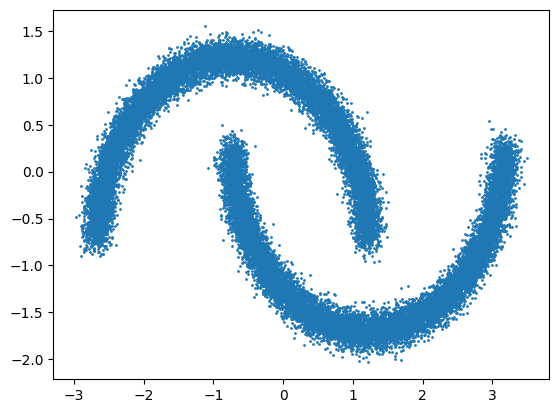

In [3]:
data = sk_datasets.make_moons(n_samples=NUM_SAMPLES, noise=5e-2)[0].astype("float32")
print("The shape of moon dataset: ", data.shape)
# data normalization
mean = data.mean()
std = data.std()
moon_data = (data - mean) / (std ** 2)
# visualize dataset
plt.scatter(moon_data[:, 0], moon_data[:, 1], s=1.0)
plt.show()

## 2. Building RealNVP

Building backbone layer

In [15]:
class FeedForward(nn.Module):
    
    activation:bool = True
    n_layers:int = 5
    dims:tuple = tuple([HIDDEN_DIM] * (n_layers - 1) + [INPUT_DIM])
    
    def setup(self):
        layers = []
        for i in range(self.n_layers):
            layers.append(nn.Dense(features=self.dims[i]))
            if i != (self.n_layers - 1):
                layers.append(nn.relu)
        if self.activation:
            layers.append(nn.tanh)
        self.network = nn.Sequential(layers)

    def __call__(self, x):
        return self.network(x)

In [21]:
ff = FeedForward()
print(ff.tabulate(jax.random.PRNGKey(0), 
                  jnp.ones((10, 2)), 
                  console_kwargs={"width": 100, 'force_terminal': False, 'force_jupyter': True})
     )

                                       FeedForward Summary                                       
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path             ┃ module      ┃ inputs          ┃ outputs         ┃ params                   ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                  │ FeedForward │ float32[10,2]   │ float32[10,2]   │                          │
├──────────────────┼─────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network          │ Sequential  │ float32[10,2]   │ float32[10,2]   │                          │
├──────────────────┼─────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_0 │ Dense       │ float32[10,2]   │ float32[10,256] │ bias: float32[256]       │
│                  │             │                 │                 │ kernel: float32[2,256]   │
│                  │             │                 │                 │                          │
│                  │             │                 │                 │ 768 (3.1 KB)             │
├──────────────────┼─────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_2 │ Dense       │ float32[10,256] │ float32[10,256] │ bias: float32[256]       │
│                  │             │                 │                 │ kernel: float32[256,256] │
│                  │             │                 │                 │                          │
│                  │             │                 │                 │ 65,792 (263.2 KB)        │
├──────────────────┼─────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_4 │ Dense       │ float32[10,256] │ float32[10,256] │ bias: float32[256]       │
│                  │             │                 │                 │ kernel: float32[256,256] │
│                  │             │                 │                 │                          │
│                  │             │                 │                 │ 65,792 (263.2 KB)        │
├──────────────────┼─────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_6 │ Dense       │ float32[10,256] │ float32[10,256] │ bias: float32[256]       │
│                  │             │                 │                 │ kernel: float32[256,256] │
│                  │             │                 │                 │                          │
│                  │             │                 │                 │ 65,792 (263.2 KB)        │
├──────────────────┼─────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│ network/layers_8 │ Dense       │ float32[10,256] │ float32[10,2]   │ bias: float32[2]         │
│                  │             │                 │                 │ kernel: float32[256,2]   │
│                  │             │                 │                 │                          │
│                  │             │                 │                 │ 514 (2.1 KB)             │
├──────────────────┼─────────────┼─────────────────┼─────────────────┼──────────────────────────┤
│                  │             │                 │           Total │ 198,658 (794.6 KB)       │
└──────────────────┴─────────────┴─────────────────┴─────────────────┴──────────────────────────┘
                                                                                                 
                              Total Parameters: 198,658 (794.6 KB)                               